In [ ]:
token='e6e35b82-5430-4f25-b584-ab400d826c1c'
json_str='{"studyIds":["blca_mskcc_solit_2014"],"pageSize":999999,"pageIndex":1,"attributesRangeFilters":[],"attributesEqualFilters":[],"mutationFilter":{"hugoGeneSymbols":[],"exacStart":0,"exadEnd":1,"vabundStart":0,"vabundEnd":1,"variantSource":[],"variantType":[],"variantClass":[],"sequencer":[],"sequencerSource":[],"searchStr":""}}'
host='https://peta.bgi.com/api'

In [42]:
# 启动python环境，并载入包
tryCatch({
    library(reticulate)
    use_condaenv("r-reticulate")#peta生产环境可用，本地机未安
    library(GenVisR)
 },error=function(e){
     print(e)
 } )

In [ ]:
# 调用pypeta获取数据
tryCatch({
    pypyta<- import("pypeta")
    peta<-pypyta$Peta(token=token,host=host)
    peta$set_data_restriction_from_json_string(json_str)
    mut<-peta$fetch_mutation_data()
    mut<-mut[which(mut$NCBI_Build != 'NA'),]
    cli<-peta$fetch_clinical_data()
    names(cli)[names(cli) =='sampleId'] <- 'Tumor_Sample_Barcode'
 },error=function(e){
     print(e)
 } )

In [ ]:
#install packages
if(FALSE){
    if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
    BiocManager::install(version = "3.12")
    #R >4.0
    BiocManager::install("GenVisR")
    #install.packages("Rcpp",type="binary") 需要的依赖包如果安装不成功使用此方法
}

In [3]:
# Load GenVisR and set seed
library("GenVisR")
#set.seed(383)

# 数据选择条件

In [ ]:
#print selected data set
tryCatch({
    json<-import("json")
    json$loads(json_str)
    pypyta$filter_description(json_str)
 },error=function(e){
     print(e)
 } )

In [91]:
mut<-read.table("./Data/data_mutations.txt",header = TRUE,sep='\t',quote ="")
cli<-read.csv("./Data/data_clinical2.txt",header = TRUE,sep='\t',quote ="")#有中文转成了ASII显示正常
#head(cli)
mut<-data.frame(mut)
cli<-data.frame(cli)

# 突变概述

NULL

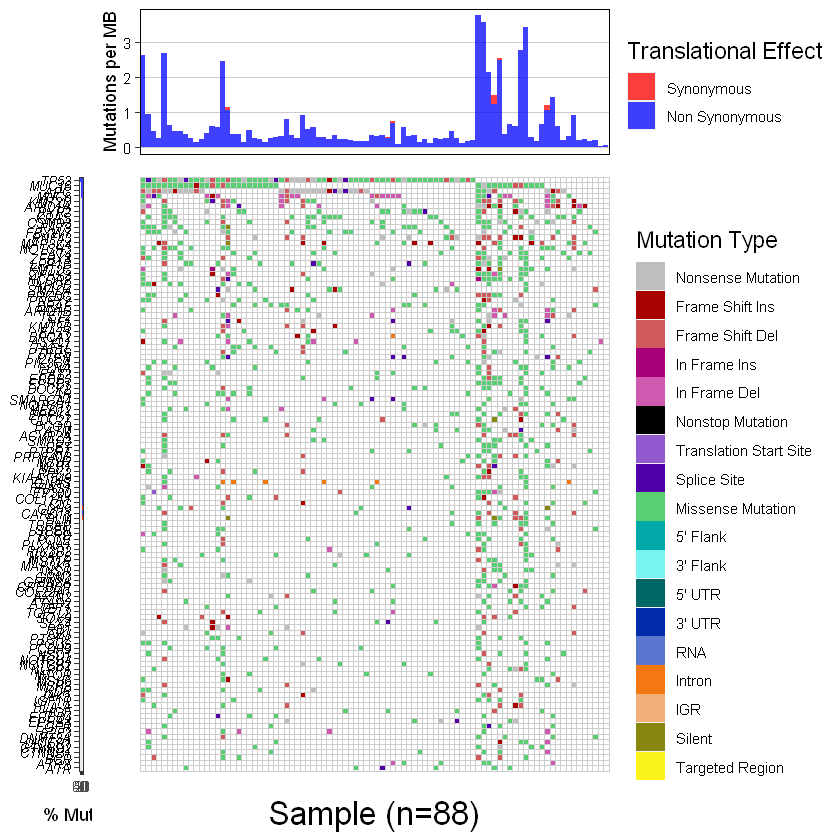

In [58]:
# Plot only genes with mutations in 6% or more of samples
#waterfall(brcaMAF, mainRecurCutoff = 0.06)
tryCatch({
    suppressMessages(suppressWarnings(waterfall(mut, mainRecurCutoff = 0.06)))
 },error=function(e){
     print(e)
 } )

NULL

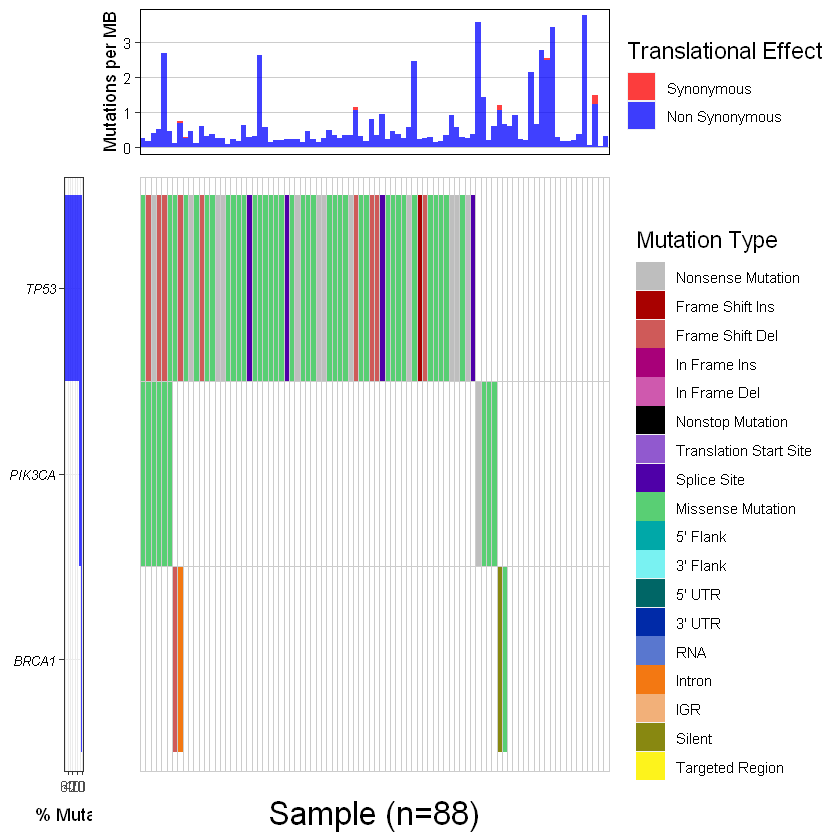

In [59]:
# Plot only the specified genes
tryCatch({
    suppressMessages(suppressWarnings(waterfall(mut, plotGenes = c("PIK3CA", "TP53", "USH2A", "MLL3", "BRCA1"))))
 },error=function(e){
     print(e)
 } )

In [77]:
# Create clinical data
subtype <- c("lumA", "lumB", "her2", "basal", "normal")
subtype <- sample(subtype, 50, replace = TRUE)
age <- c("20-30", "31-50", "51-60", "61+")
age <- sample(age, 50, replace = TRUE)
sample <- as.character(unique(brcaMAF$Tumor_Sample_Barcode))
clinical <- as.data.frame(cbind(sample, subtype, age))

# Melt the clinical data into 'long' format.
library(reshape2)
clinical <- melt(clinical, id.vars = c("sample"))
head(clinical)

,sample,variable,value
,<chr>,<fct>,<chr>
1,TCGA-A1-A0SO-01A-22D-A099-09,subtype,lumB
2,TCGA-A2-A0EU-01A-22W-A071-09,subtype,her2
3,TCGA-A2-A0ER-01A-21W-A050-09,subtype,lumB
4,TCGA-A2-A0EN-01A-13D-A099-09,subtype,normal
5,TCGA-A1-A0SI-01A-11D-A142-09,subtype,her2
6,TCGA-A2-A0D0-01A-11W-A019-09,subtype,lumB


In [84]:
##中文会报错
can_ty<-as.character(cli$CANCER_TYPE)
#can_ty
sex<-as.character(cli$SEX)
sample <- as.character(cli$sampleId)
msi<-as.character(cli$MSI_STATUS)
result<-as.character(cli$GENETIC_TEST_RESULT)
# Recreate clinical data
clinical <- as.data.frame(cbind(sample, msi, result))

# Melt the clinical data into 'long' format.
library(reshape2)
clinical <- melt(clinical, id.vars = c("sample"))
head(clinical)

,sample,variable,value
,<chr>,<fct>,<chr>
1,19S3195242,msi,NA
2,19S3195291,msi,NA
3,19S3195292,msi,NA
4,19S3195286,msi,NA
5,19S3195287,msi,NA
6,19S3195295,msi,NA


NULL

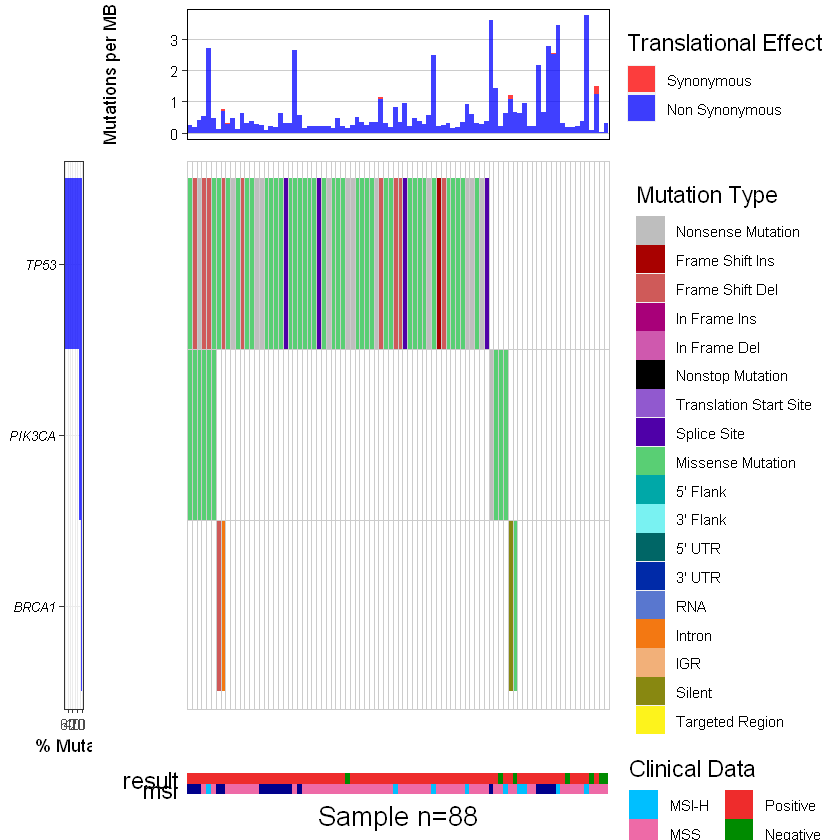

In [86]:
# Run waterfall
tryCatch({
    suppressMessages(suppressWarnings(waterfall(mut, clinDat = clinical, clinVarCol = c(`NA` = "blue4", 
    `MSI-H` = "deepskyblue", MSS = "hotpink2", Positive = "firebrick2", Negative = "green4"), plotGenes = 
    c("PIK3CA", "TP53", "USH2A", "MLL3", "BRCA1"), clinLegCol = 2, clinVarOrder = c("NA", "MSI-H", "MSS",
    "Positive", "Negative")) ))
 },error=function(e){
     print(e)
 } )


# 突变热点 

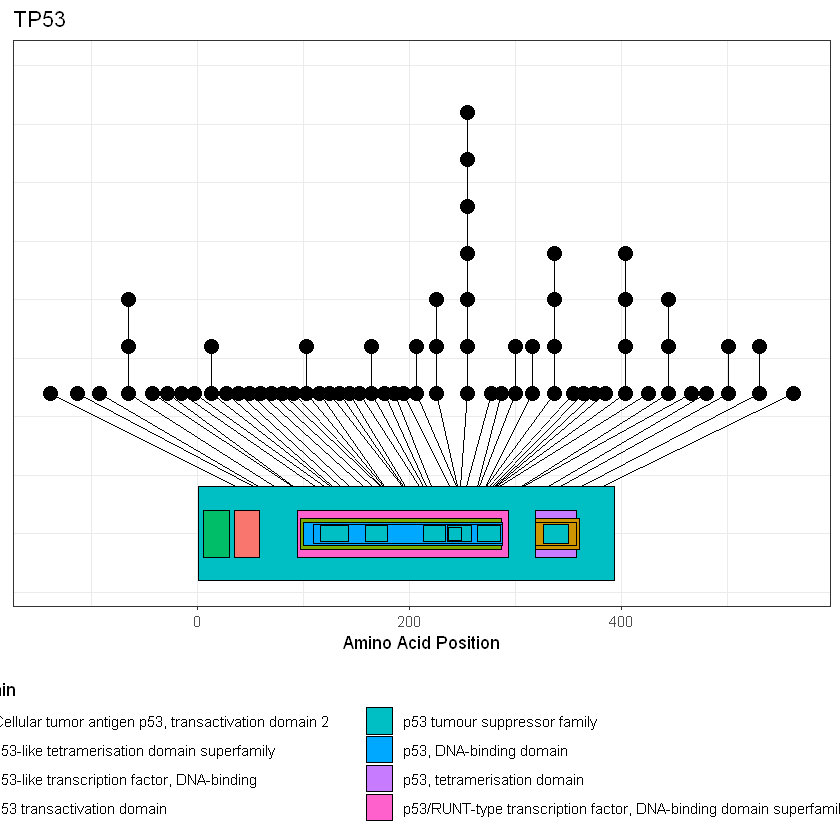

In [104]:
# Create input data
data <- mut[mut$Hugo_Symbol == "TP53", c("Hugo_Symbol", "HGVSp_Short")]#format p.R383A
data <- as.data.frame(cbind(data, "ENST00000269305"))
colnames(data) <- c("gene", "amino_acid_change", "transcript_name")

# Call lolliplot
tryCatch({
    suppressMessages(suppressWarnings(lolliplot(data)))
},error=function(e){
     print(e)
 }
)

In [130]:
# Add additional columns to the data
#data$gene
pID <- as.data.frame(mut[mut$Hugo_Symbol == "TP53", c("Tumor_Sample_Barcode")])
#class(pID)
#pID
gender <-apply(pID,1,function(x){cli[cli$patientId == x,c("SEX")]})
data$gender <- gender
data$Variant_Type <- mut[mut$Hugo_Symbol == "TP53", c("Variant_Type")]
colnames(data) <- c("gene","amino_acid_change","transcript_name","gender","Variant_Type")
#data$Variant_Type

[1] "SNP" "SNP" "SNP" "SNP" "DEL" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP"
[13] "SNP" "SNP" "SNP" "SNP" "DEL" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP"
[25] "SNP" "DEL" "SNP" "SNP" "INS" "SNP" "SNP" "SNP" "DEL" "SNP" "SNP" "SNP"
[37] "DEL" "DEL" "SNP" "SNP" "SNP" "DEL" "DEL" "DEL" "SNP" "SNP" "SNP" "SNP"
[49] "SNP" "SNP" "SNP" "INS" "DEL" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP"
[61] "SNP" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP" "SNP" "DEL" "SNP" "SNP" "SNP"

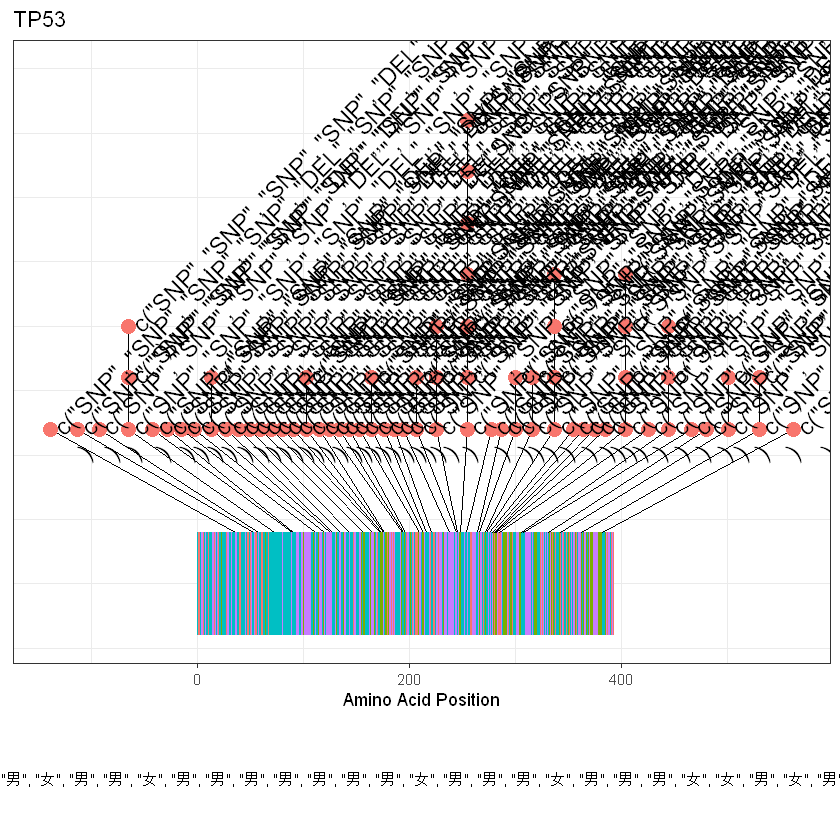

In [125]:
# Add additional columns to the data
#data$gene
pID <- as.data.frame(mut[mut$Hugo_Symbol == "TP53", c("Tumor_Sample_Barcode")])
#class(pID)
#pID
gender <-as.data.frame(apply(pID,1,function(x){cli[cli$patientId == x,c("SEX")]}))
data$gender <- gender
data$Variant_Type <- as.data.frame(mut[mut$Hugo_Symbol == "TP53", c("Variant_Type")])
colnames(data) <- c("gene", "amino_acid_change", "transcript_name","gender","Variant_Type")
# Call lolliplot
tryCatch({
    suppressMessages(suppressWarnings(lolliplot(data, fillCol = "gender", labelCol = "Variant_Type", sideChain = TRUE)))
},error=function(e){
     print(e)
 }
)

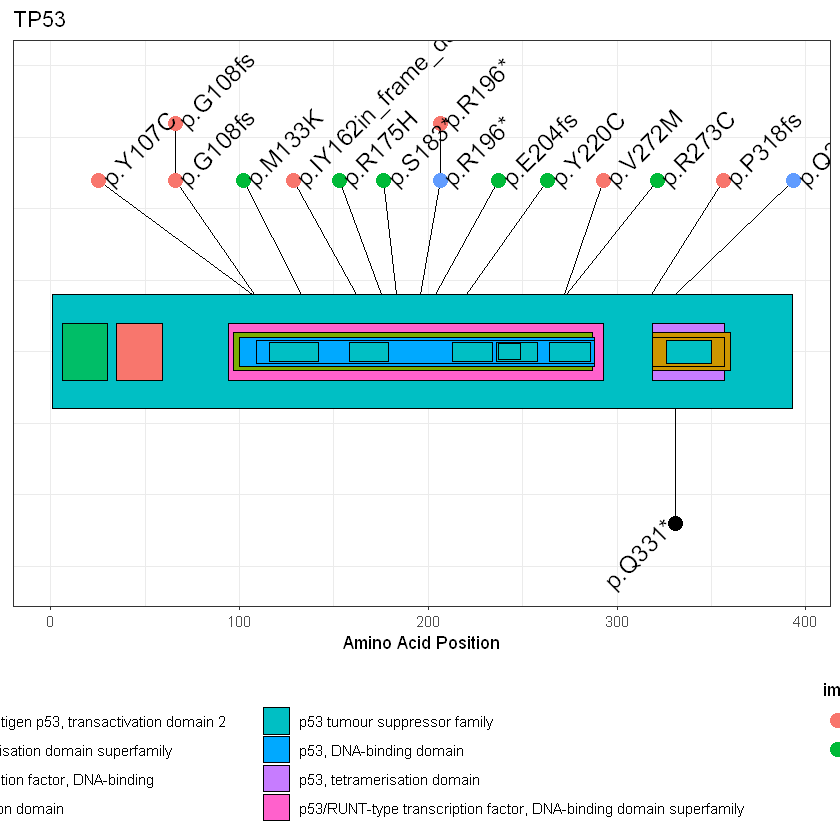

In [23]:
# Create additional data
data2 <- data.frame(transcript_name = "ENST00000269305", amino_acid_change = "p.R248W")

# Call lolliplot
tryCatch({
    suppressMessages(suppressWarnings(lolliplot(data, y = data2, fillCol = "gender", labelCol = "amino_acid_change")))
},error=function(e){
     print(e)
 })


#  测序覆盖情况

Loading required package: GenomicFeatures

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4




NULL

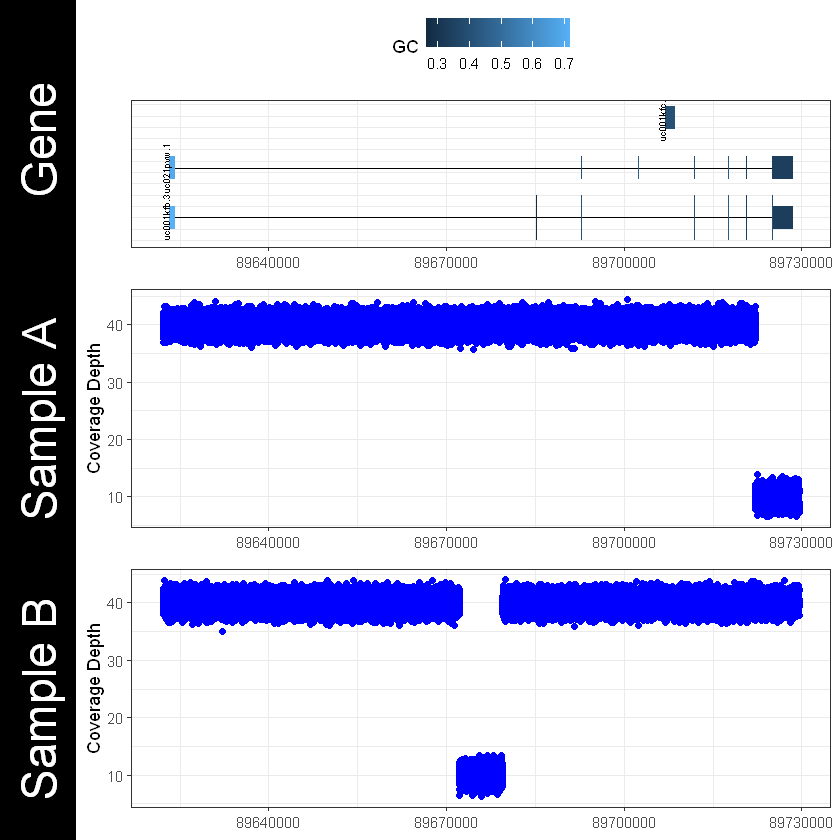

In [35]:
# Load transcript meta data
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene

# Load BSgenome
library(BSgenome.Hsapiens.UCSC.hg19)
genome <- BSgenome.Hsapiens.UCSC.hg19

# Define a region of interest
gr <- GRanges(seqnames = c("chr10"), ranges = IRanges(start = c(89622195), end = c(89729532)), 
    strand = strand(c("+")))

# Create Data for input
start <- c(89622194:89729524)
end <- c(89622195:89729525)
chr <- 10
cov <- c(rnorm(1e+05, mean = 40), rnorm(7331, mean = 10))
cov_input_A <- as.data.frame(cbind(chr, start, end, cov))

start <- c(89622194:89729524)
end <- c(89622195:89729525)
chr <- 10
cov <- c(rnorm(50000, mean = 40), rnorm(7331, mean = 10), rnorm(50000, mean = 40))
cov_input_B <- as.data.frame(cbind(chr, start, end, cov))

# Define the data as a list
data3 <- list(`Sample A` = cov_input_A, `Sample B` = cov_input_B)

# Call genCov
tryCatch({
    suppressMessages(suppressWarnings(
        genCov(data3, txdb, gr, genome, gene_labelTranscriptSize = 2, transform = NULL, base = NULL)))
},error=function(e){
     print(e)
 })


In [ ]:
# Turn off feature compression and reduce gene transcripts
genCov(data3, txdb, gr, genome, transform = c("Intron", "CDS", "UTR"), base = c(10, 2, 2), reduce = TRUE)

# Tr/Ti图

  |======================================================================| 100%


NULL

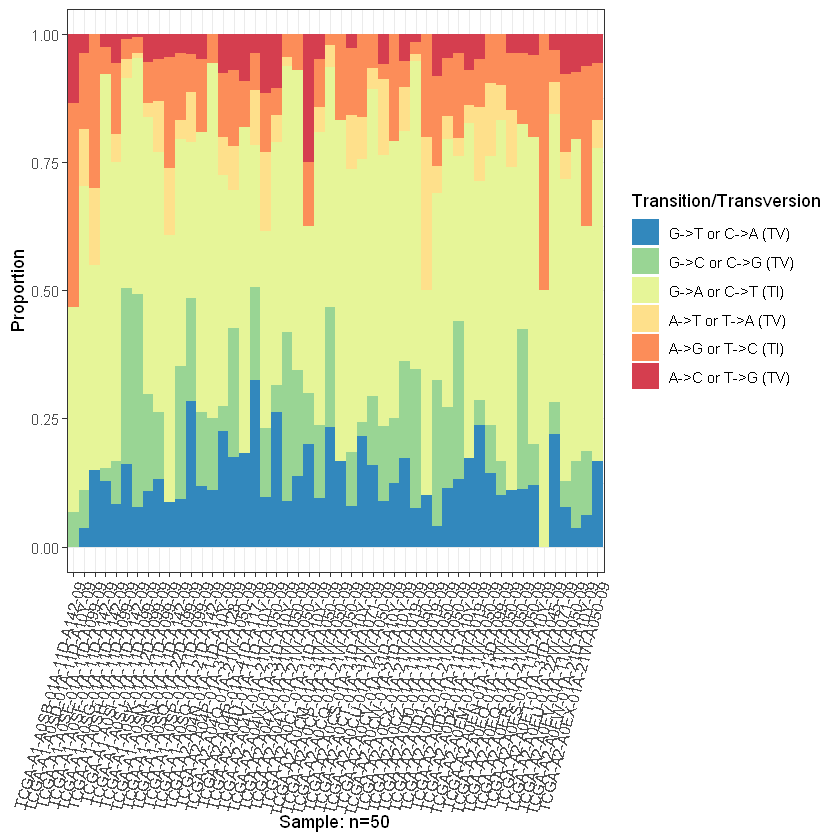

In [25]:
# Call TvTi
tryCatch({
    suppressMessages(suppressWarnings(TvTi(mut, lab_txtAngle=75, fileType="MAF")))
},error = function(e){
    print(e)
})


  |======================================================================| 100%


NULL

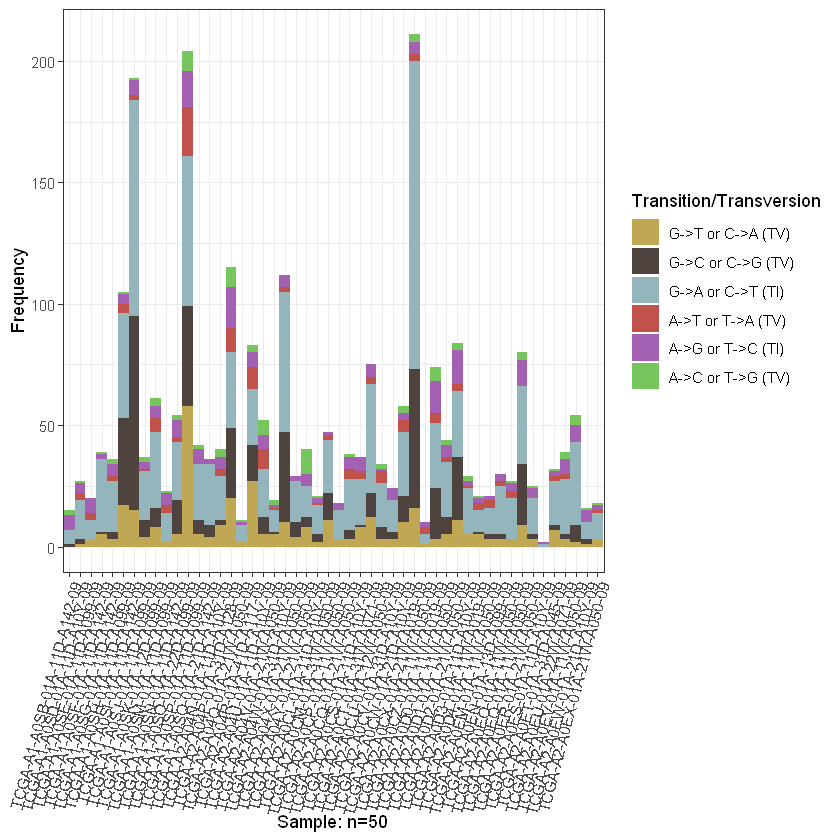

In [26]:
# Plot the frequency with a different color pallete
tryCatch({
    suppressMessages(suppressWarnings(TvTi(mut, type = "Frequency", palette = c("#77C55D", "#A461B4", "#C1524B", "#93B5BB", 
    "#4F433F", "#BFA753"), lab_txtAngle = 75, fileType = "MAF")))
},error = function(e){
    print(e)
})

  |======================================================================| 100%


NULL

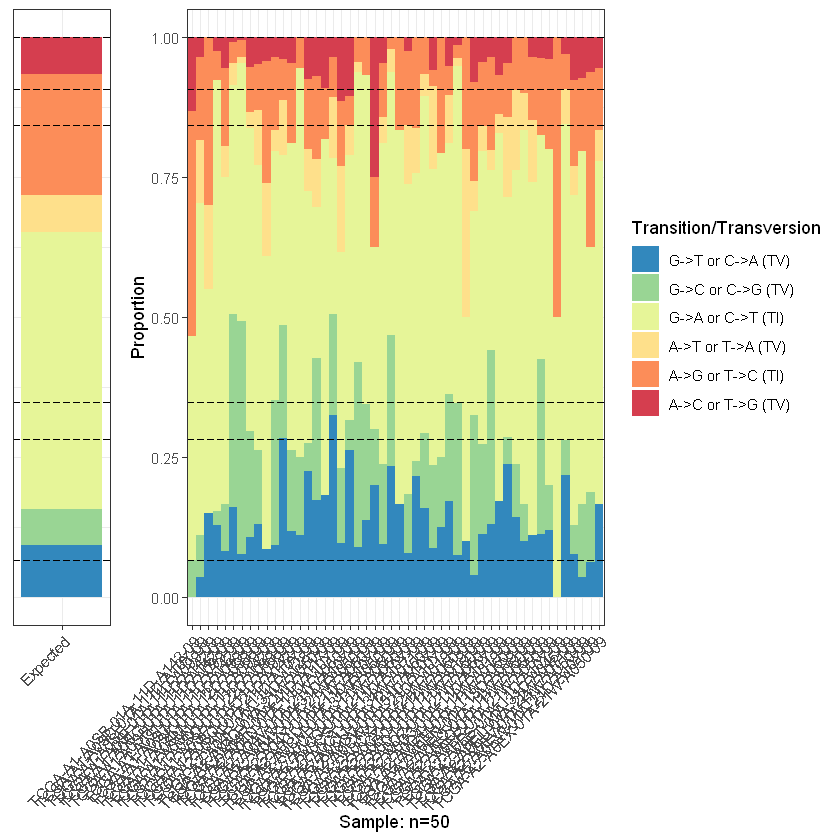

In [28]:
# Create a named vector of apriori expectations
expec <- c(`A->C or T->G (TV)` = 0.066, `A->G or T->C (TI)` = 0.217, `A->T or T->A (TV)` = 0.065, 
    `G->A or C->T (TI)` = 0.4945, `G->C or C->G (TV)` = 0.0645, `G->T or C->A (TV)` = 0.093)

# Call TvTi with the additional data
tryCatch({
    suppressMessages(suppressWarnings(TvTi(mut, y = expec, lab_txtAngle = 45, fileType = "MAF")))
},error = function(e){
    print(e)
})

# 样本水平拷贝数变异

NULL

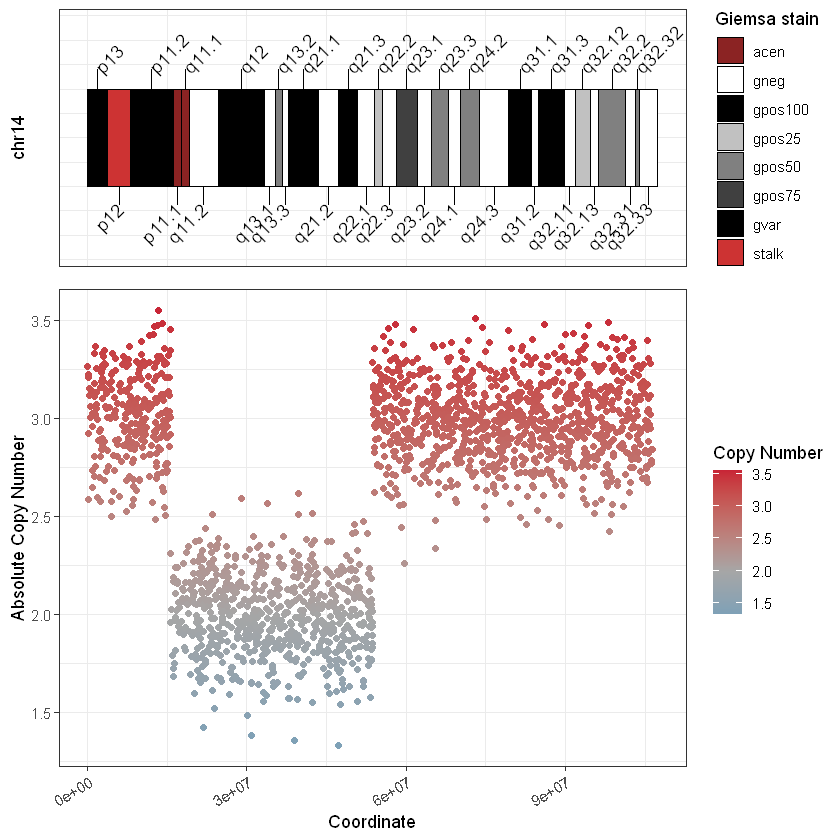

In [30]:
# Create data
chromosome <- "chr14"
coordinate <- sort(sample(0:106455000, size = 2000, replace = FALSE))
cn <- c(rnorm(300, mean = 3, sd = 0.2), rnorm(700, mean = 2, sd = 0.2), rnorm(1000, 
    mean = 3, sd = 0.2))
data4 <- as.data.frame(cbind(chromosome, coordinate, cn))

# Call cnView with basic input
tryCatch({
    suppressMessages(suppressWarnings(cnView(data4, chr = "chr14", genome = "hg19", ideogram_txtSize = 4)))
},error = function(e){
    print(e)
})

In [ ]:
# create copy number data
chromosome <- "chr14"
coordinate <- sort(sample(0:106455000, size = 2000, replace = FALSE))
cn <- c(rnorm(300, mean = 3, sd = 0.2), rnorm(700, mean = 2, sd = 0.2), rnorm(1000, 
    mean = 3, sd = 0.2))
data5 <- as.data.frame(cbind(chromosome, coordinate, cn))

# create segment data
dataSeg <- data.frame(chromosome = c(14, 14, 14), start = coordinate[c(1, 301, 1001)], 
    end = coordinate[c(300, 1000, 2000)], segmean = c(3, 2, 3))
# call cnView with included segment data
cnView(data5, z = dataSeg, chr = "chr14", genome = "hg19", ideogram_txtSize = 4)

# 群体水平测序覆盖度

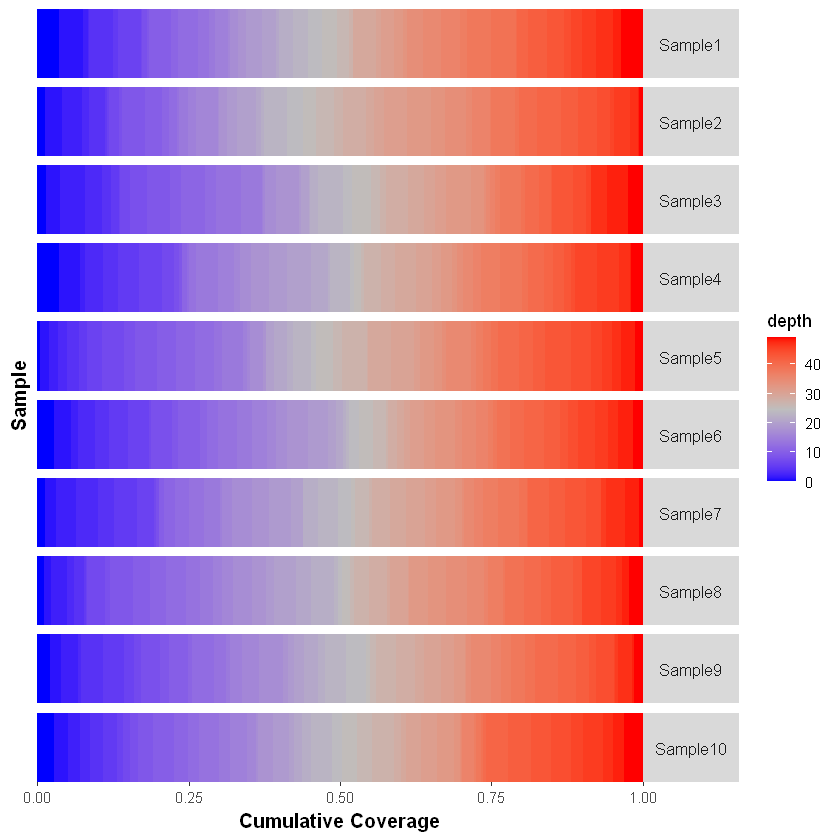

In [31]:
# Example input to x
x <- matrix(sample(1e+05, 500), nrow = 50, ncol = 10, dimnames = list(0:49, paste0("Sample", 
    1:10)))
tryCatch({
    suppressMessages(suppressWarnings(covBars(x, colour = c("blue", "grey", "red"))))
},error = function(e){
    print(e)
})

# 拷贝数变异比例

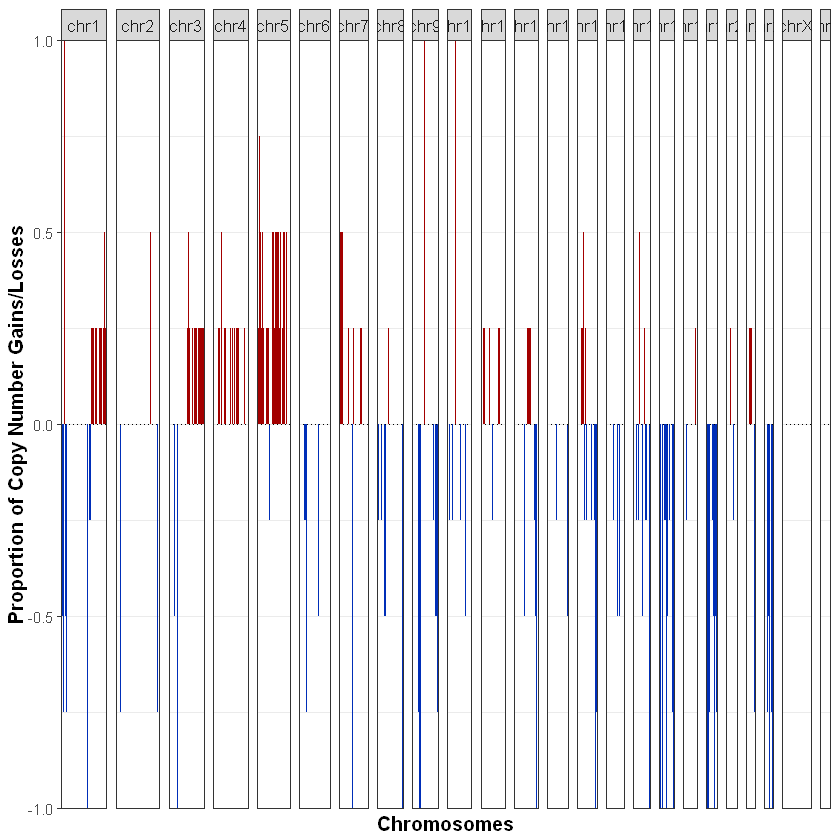

In [32]:
#cnFreq (proportional copy number alterations)
tryCatch({
    suppressMessages(suppressWarnings(cnFreq(LucCNseg)))
},error = function(e){
    print(e)
})

# 染色体示意图

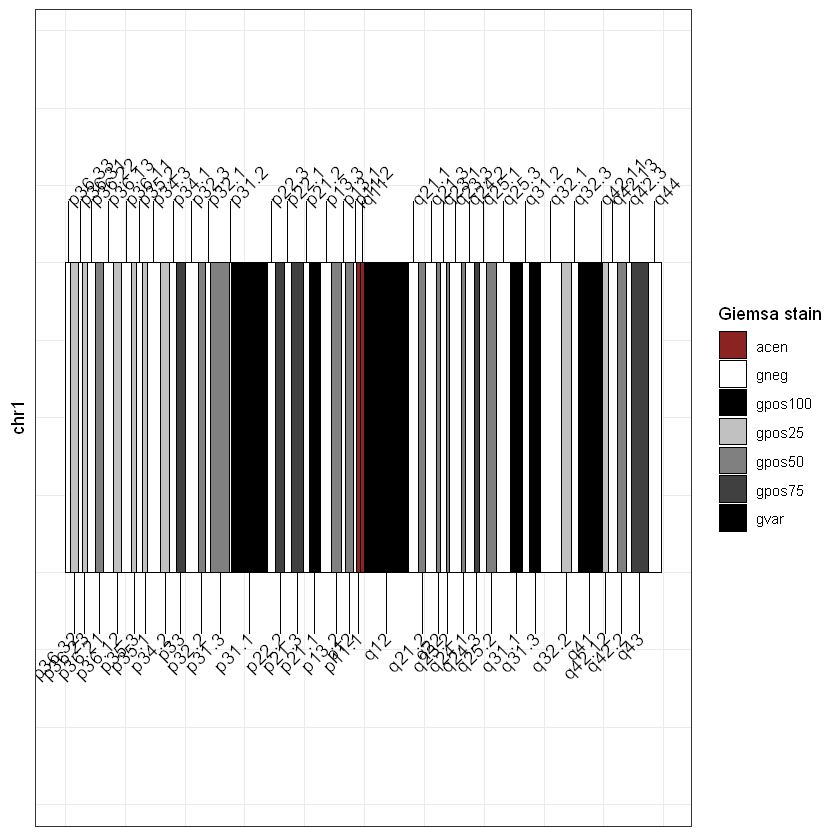

In [36]:
# Obtain cytogenetic information for the genome of interest
data <- cytoGeno[cytoGeno$genome == "hg38", ]

# Call ideoView for chromosome 1
tryCatch({
    suppressMessages(suppressWarnings(ideoView(data, chromosome = "chr1", txtSize = 4)))
},error = function(e){
    print(e)
})

# LOH图谱

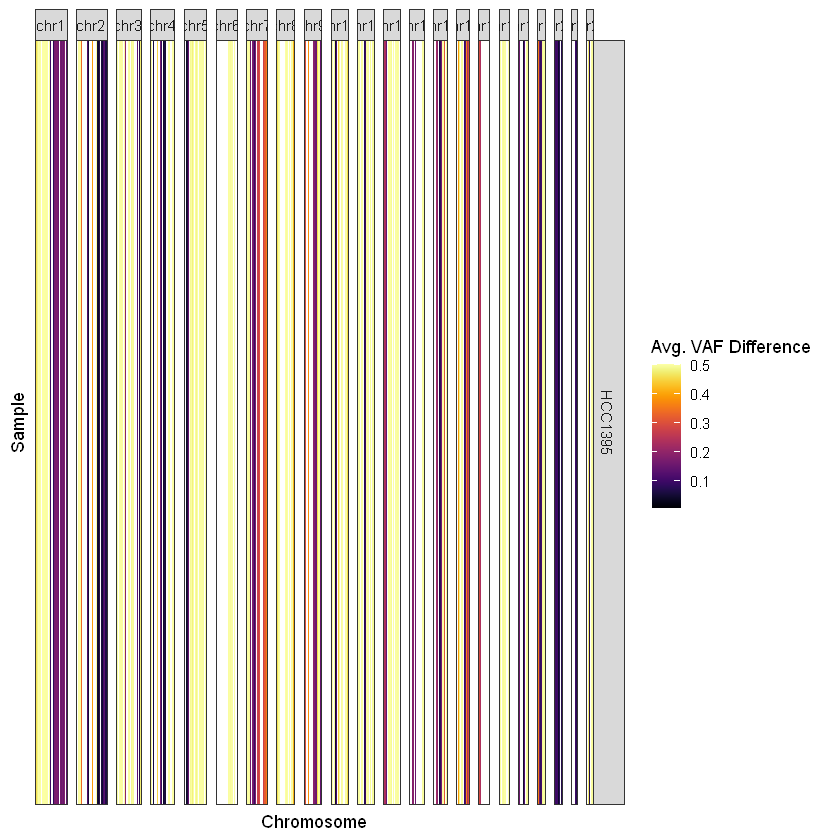

In [37]:
# Call lohSpec with basic input
tryCatch({
    suppressMessages(suppressWarnings(lohSpec(x = HCC1395_Germline)))
},error = function(e){
    print(e)
})

# 染色体水平LOH

NULL

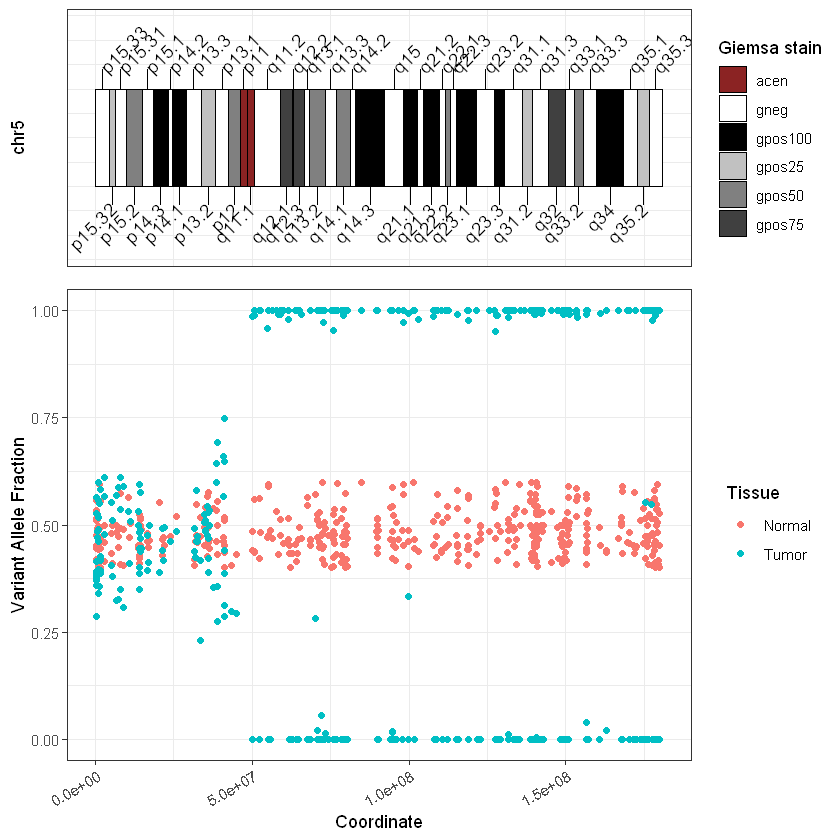

In [38]:
# Call lohView with basic input, make sure input contains only Germline calls
tryCatch({
    suppressMessages(suppressWarnings(lohView(HCC1395_Germline, chr = "chr5", genome = "hg19", ideogram_txtSize = 4)))
},error = function(e){
    print(e)
})

# SNP变异频率差异分析

NULL

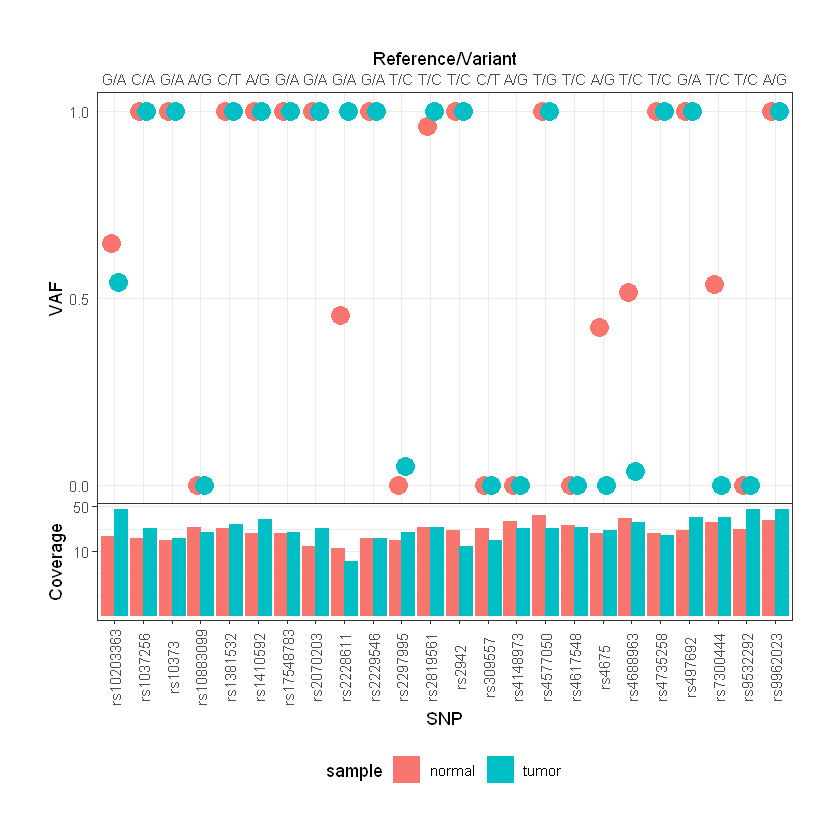

In [39]:
# Read in BSgenome object (hg19)
#library(BSgenome.Hsapiens.UCSC.hg19)
hg19 <- BSgenome.Hsapiens.UCSC.hg19

# Generate plot
tryCatch({
    suppressMessages(suppressWarnings(compIdent(genome = hg19, debug = TRUE)))
},error = function(e){
    print(e)
})

# 基因视图

Obtaining CDS Coordinates

'select()' returned 1:many mapping between keys and columns

Obtaining UTR Coordinates

'select()' returned 1:many mapping between keys and columns

Calculating transform



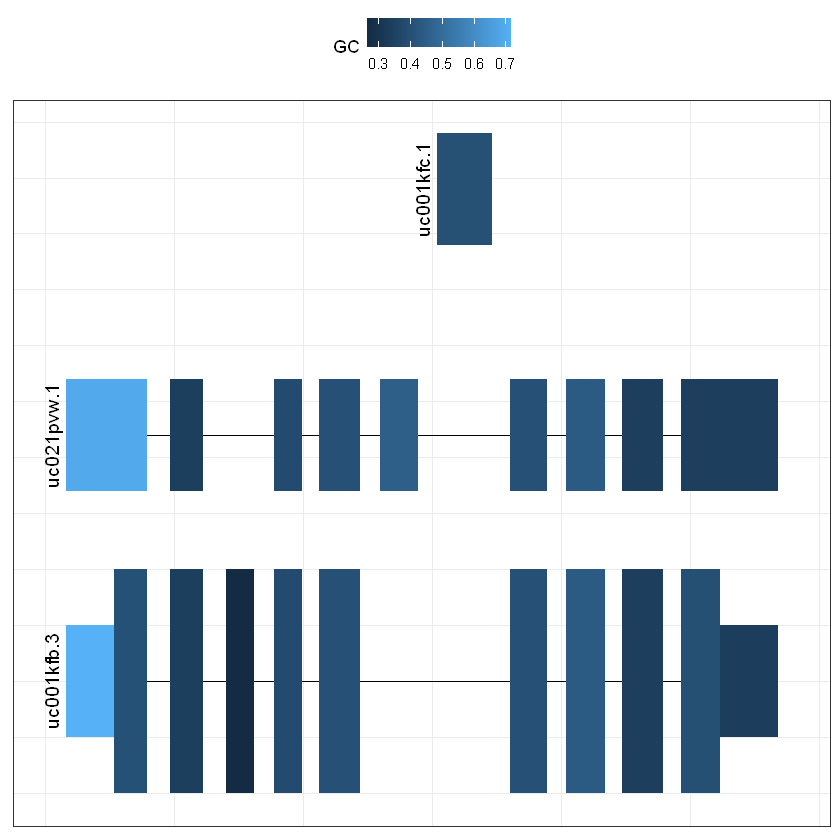

In [40]:
# need transcript data for reference
txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene

# need a biostrings object for reference
genome <- BSgenome.Hsapiens.UCSC.hg19

# need Granges object
gr <- GRanges(seqnames = c("chr10"), ranges = IRanges(start = c(89622195), end = c(89729532)), 
    strand = strand(c("+")))

# Plot and call the graphic
p1 <- geneViz(txdb, gr, genome)
p1[[1]]